In [1]:
from elasticsearch import Elasticsearch
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv 
import os
load_dotenv()


/Users/liguanwei/Github/HIS-ELK-weekly-report/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

In [2]:
client = Elasticsearch(
    "https://192.168.101.11:9200",  # Elasticsearch endpoint
    api_key=os.getenv("ELASTICSEARCH_API_KEY"),
    verify_certs=False
)

/Users/liguanwei/Github/HIS-ELK-weekly-report/.venv/lib/python3.9/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://192.168.101.11:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [3]:
with open('./api-json-template/docker-cpu-usage.json', 'r') as file:
    query = json.load(file)

In [4]:
# Calculate timestamps for gte and lte
now = datetime.now()
week_ago = now - timedelta(weeks=1)

# Format timestamps as strings
gte_timestamp = week_ago.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
lte_timestamp = now.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

# Update the query with formatted timestamps
query['query']['bool']['filter'][2]['range']['@timestamp']['gte'] = gte_timestamp
query['query']['bool']['filter'][2]['range']['@timestamp']['lte'] = lte_timestamp


In [5]:

# Execute the search query
response = client.search(index="*", body=query)

/Users/liguanwei/Github/HIS-ELK-weekly-report/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.101.11'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [6]:
# Print the response
data = response

In [7]:
# Extract the aggregation data
buckets = data['aggregations']['0']['buckets']

# Transform data into a DataFrame
df = pd.DataFrame(buckets)

# Extract the nested values
df['user'] = df['1'].apply(lambda x: x['value'])
df['system'] = df['2'].apply(lambda x: x['value'])
df['nice'] = df['3'].apply(lambda x: x['value'])
df['irq'] = df['4'].apply(lambda x: x['value'])
df['softirq'] = df['5'].apply(lambda x: x['value'])
df['iowait'] = df['6'].apply(lambda x: x['value'])

In [8]:
# Drop the original nested columns
df.drop(columns=['1', '2', '3', '4', '5', '6'], inplace=True)

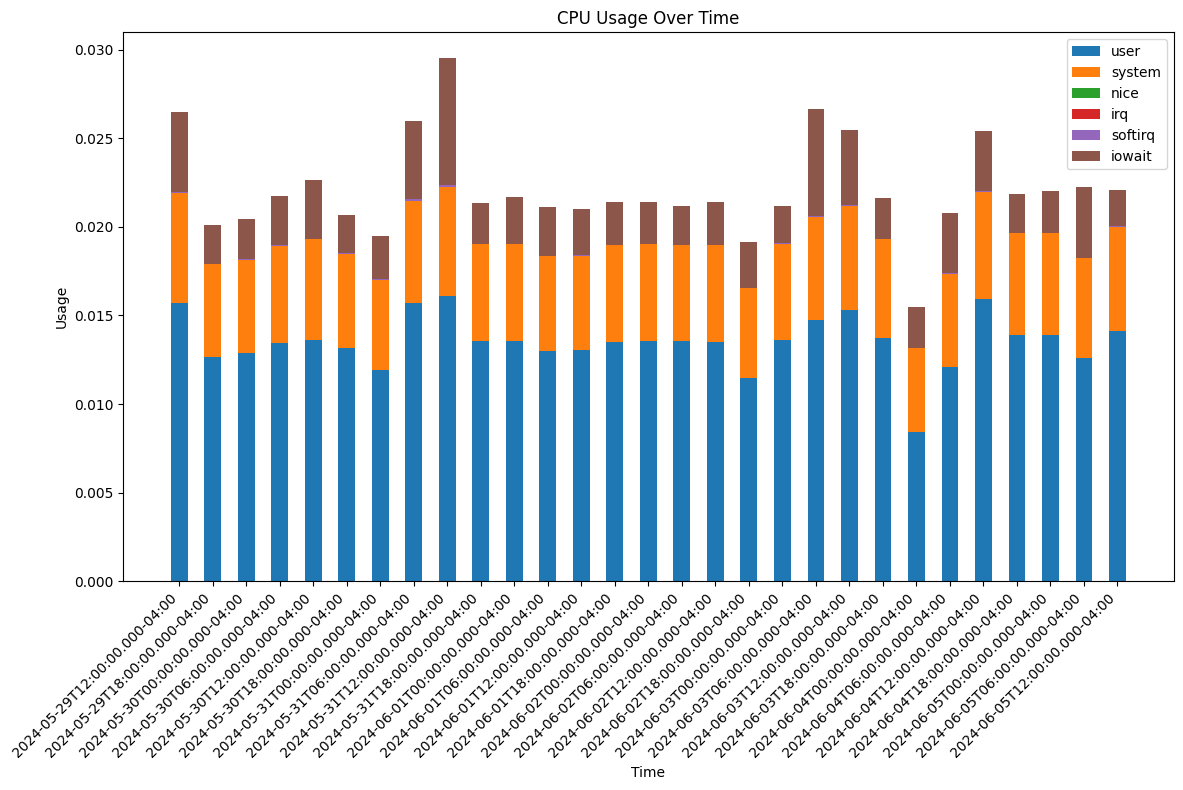

In [9]:
# Plotting the vertical stacked bar plot
plt.figure(figsize=(12, 8))

# Set x-axis labels
x_labels = df['key_as_string']

# Plotting stacked bars
plt.bar(x_labels, df['user'], width=0.5, align='center', label='user')
plt.bar(x_labels, df['system'], bottom=df['user'], width=0.5, align='center', label='system')
plt.bar(x_labels, df['nice'], bottom=df['user'] + df['system'], width=0.5, align='center', label='nice')
plt.bar(x_labels, df['irq'], bottom=df['user'] + df['system'] + df['nice'], width=0.5, align='center', label='irq')
plt.bar(x_labels, df['softirq'], bottom=df['user'] + df['system'] + df['nice'] + df['irq'], width=0.5, align='center', label='softirq')
plt.bar(x_labels, df['iowait'], bottom=df['user'] + df['system'] + df['nice'] + df['irq'] + df['softirq'], width=0.5, align='center', label='iowait')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Usage')
plt.title('CPU Usage Over Time')

# Show plot
plt.tight_layout()
plt.show()
